# Import and settings

In [ ]:
# Imports and settings.
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from torch.autograd import Variable
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import fbeta_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.exceptions import UndefinedMetricWarning
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
!pip install transformers
from transformers import BertTokenizer
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertForSequenceClassification, AdamW, BertConfig,BertModel
from transformers import get_linear_schedule_with_warmup



warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

     |████████████████████████████████| 890kB 2.4MB/s 
     |████████████████████████████████| 3.0MB 7.4MB/s 
     |████████████████████████████████| 1.1MB 28.3MB/s 
     |████████████████████████████████| 890kB 29.0MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=2181ac794878334b4c9c53f45cbdd4c0b44c8e32cca056968d32e17558edf4e3
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
#Download Tec, CF and Wang datasets
!git clone https://gitlab.com/Georgios.Hadjiharalambous/emotion-detection-in-short-texts-datasets
!cp './emotion-detection-in-short-texts-datasets/CrowdFlower.csv' 'CrowdFlower.csv'
!cp './emotion-detection-in-short-texts-datasets/Wang.csv' 'Wang.csv'
!cp './emotion-detection-in-short-texts-datasets/TEC.csv' 'TEC.csv'

Cloning into 'emotion-detection-in-short-texts-datasets'...
remote: Enumerating objects: 10, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 10 (delta 1), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (10/10), done.


# Model defintion

In [ ]:
#This class is the implementation of Bert hierarchical classifier.
#We use the Bert model implementation as provided by the huggingface library
#Link can be fount at https://huggingface.co/transformers/_modules/transformers/modeling_bert.html

class BertClassifierHier(nn.Module):
    def __init__(self, model_name, num_labels, dropout_prob=0.5, bert_hidden_size=768):
      
        # Initializes the BertClassifier model object.
      
        # Parameters:
        #     model_name: {String} exact name of the Bert model to be used during training. (Usually "bert-base-uncased")
        #     num_labels: {int} Number of labels.
        #     dropout_prob : {float} The dropout probability for the classification layer.
        #     bert_hidden_size: {int} Bert hidden dimension for its last-output layer. (Usually for "bert-base-uncased" is 768)
        
        super().__init__()
        self.num_labels = num_labels
        self.bert = BertModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(dropout_prob)
        self.l1_bin = nn.Linear(bert_hidden_size,1)#for the binary category classifier (output: negative/positive)
        self.l2_mul= nn.Linear(bert_hidden_size, self.num_labels - 1)#for the negative category classifier (output: sadness/fear/anger)

    def forward(self, input_ids = None, attention_mask = None, negative_index = None):
        # Processes the input data to produce the classification output and the attention weight tensor.

        # Parameters:
        #     input_data: {torch.Tensor} Input data.
        #     attention_mask: {torch.Tensor} Indices to avoid performing attention to due to padded tokens
        #     negative_index: {list} List of indices of rows in input_data that represent dataset entries belonging to negative emotion classes.
        #                     Only employed during model training.
        
        outputs = self.bert(input_ids, attention_mask = attention_mask)
        pooled_output = outputs[1]
        pooled_output = self.dropout(pooled_output)

        #binary classification
        outputs_bin = self.l1_bin(pooled_output)
        outputs_bin = torch.sigmoid(outputs_bin)
        output_mul=pooled_output

        #mutliclass-negative emotion classification
        if negative_index is not None:
          output_mul=pooled_output[negative_index]#use only the negative examples for training of the second classifier.
        output_mul = self.l2_mul(output_mul)
        output_mul = torch.log_softmax(output_mul,1) 

        return outputs_bin, output_mul  

# Evaluation functions

In [ ]:
def get_classes_stats(predicted_output, true_output):

    # Returns the calculated evaluation metrics for each class.
    
    # Parameters:
    #     predicted_output: {numpy.array} Predicted output.
    #     true_output: {numpy.array} True output.

    report_dict = classification_report(true_output, predicted_output, output_dict=True)
    classes = []
    classes_stats = []
    for key in report_dict:
        if key not in ["accuracy", "macro avg", "weighted avg"]:
          classes.append(int(float(key)))
          stats = [float("%0.3f" % (report_dict[key]['precision'])), float("%0.3f" % (report_dict[key]['recall'])), 
                    float("%0.3f" % (report_dict[key]['f1-score'])), report_dict[key]['support']]
          classes_stats.append(stats)
    return [classes, classes_stats]
def create_report(parameters, run_function, num_classes, num_iters):

    # Creates an overall evaluation report after training and testing a model on binary or multiclass classification for a set number of iterations.

    # Parameters:
    #     parameters: {list} List of parameters.
    #     run_function: {function} Function to train and test a model on binary or multiclass classification.
    #     num_classes: {int} Number of classes.
    #     num_iters: {int} Number of iterations.

    accuracy_list = []
    precision_list = []
    recall_list = []
    f1_list = []
    classes = {}
    print("CREATING REPORT:")
    for i in range(num_iters):
        print("Run: " + str(i + 1))
        result = run_function(parameters[0], parameters[1], parameters[2], parameters[3], False)
        print("Accuracy: %0.3f" % result[0][0])
        print("Precision (WEIGHT_AVG): %0.3f" % result[0][1])
        print("Recall (WEIGHT_AVG): %0.3f" % result[0][2])
        print("F1 (WEIGHT_AVG): %0.3f" % result[0][3])
        accuracy_list.append(result[0][0])
        precision_list.append(result[0][1])
        recall_list.append(result[0][2])
        f1_list.append(result[0][3])
        for j in range(1, num_classes + 1, 1):
            print((str(result[j][0]) + " | Precision: %0.3f Recall: %0.3f F1: %0.3f") % (result[j][1], result[j][2], result[j][3]))
            if result[j][0] not in classes:
                classes[result[j][0]] = {}
            if "Precision_List" not in classes[result[j][0]]:
                classes[result[j][0]]["Precision_List"] = []
            classes[result[j][0]]["Precision_List"].append(result[j][1])
            if "Recall_List" not in classes[result[j][0]]:
                classes[result[j][0]]["Recall_List"] = []
            classes[result[j][0]]["Recall_List"].append(result[j][2])
            if "F1_List" not in classes[result[j][0]]:
                classes[result[j][0]]["F1_List"] = []
            classes[result[j][0]]["F1_List"].append(result[j][3])
    general_stats = [["%0.3f [%0.3f]" % (np.mean(np.asarray(accuracy_list)), np.std(np.asarray(accuracy_list))), 
                      "%0.3f [%0.3f]" % (np.mean(np.asarray(precision_list)), np.std(np.asarray(precision_list))), 
                      "%0.3f [%0.3f]" % (np.mean(np.asarray(recall_list)), np.std(np.asarray(recall_list))), 
                      "%0.3f [%0.3f]" % (np.mean(np.asarray(f1_list)), np.std(np.asarray(f1_list)))]]
    class_labels = []
    class_stats = []
    for key in classes:
        class_labels.append(key)
        precision = "%0.3f [%0.3f]" % (np.mean(np.asarray(classes[key]["Precision_List"])), np.std(np.asarray(classes[key]["Precision_List"])))
        recall = "%0.3f [%0.3f]" % (np.mean(np.asarray(classes[key]["Recall_List"])), np.std(np.asarray(classes[key]["Recall_List"])))
        f1 = "%0.3f [%0.3f]" % (np.mean(np.asarray(classes[key]["F1_List"])), np.std(np.asarray(classes[key]["F1_List"])))
        class_stats.append([precision, recall, f1])
    fig = plt.figure()
    ax = fig.add_subplot(3, 1, 1)  
    col_labels = ["Accuracy [STD]", "Precision (WEIGHT_AVG) [STD]", "Recall (WEIGHT_AVG) [STD]", "F1 (WEIGHT_AVG) [STD]"]
    table = ax.table(cellText=general_stats, rowLabels=[parameters[0]], colLabels=col_labels, loc='center')
    table.scale(3, 3)
    ax.axis('off')
    ax = fig.add_subplot(3, 1, 3)
    col_labels = ["Precision [STD]", "Recall [STD]", "F1 [STD]"]
    table = ax.table(cellText=class_stats, rowLabels=class_labels, colLabels=col_labels, loc='center')
    table.scale(3, 3)
    ax.axis('off')

def plot_confusion_matrix(description, predicted_output, true_output, labels_dict, normalize=False):

    # Plots a confusion matrix for the predicted output.

    # Parameters:
    #     description: {str} Description.
    #     predicted_output: {numpy.array} Predicted output.
    #     true_output: {numpy.array} True output.
    #     labels_dict: {dict} Dictionary of class labels.
    #     normalize: {bool} Normalize values or not.

    title = "Confusion matrix: '%s'" % (description)
    if normalize:
        title = title + " (Normalized)"
    cm = confusion_matrix(true_output, predicted_output)
    classes = get_classes_stats(predicted_output, true_output)[0]
    labels = []
    for item in classes:
        labels.append(labels_dict[item])
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    fig = plt.figure(figsize=(12, 12))
    ax = fig.add_subplot(1, 1, 1)
    cmap = plt.cm.Blues
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]), yticklabels=labels)
    ax.set_xticklabels(labels, rotation='vertical')
    ax.set_title(title, fontsize=20)
    ax.set_ylabel("True labels", fontsize=20)
    ax.set_xlabel("Predicted labels", fontsize=20)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt), ha="center", va="center", color="white" if cm[i, j] > thresh else "black")
    ax.grid(False)

# Dataset loading and processing functions

In [ ]:
def load_tec_hierarchical_model():

    # Loads the TEC dataset for multiclass classification with the Bert(Hier) model.

    labels_dict = {0: "Anger", 1: "Fear", 2: "Sadness", 3: "Happiness"}
    dataframe = pd.read_csv("TEC.csv", delimiter=",", dtype={"id": int, "text": str, "emotion": str})
    dataframe = dataframe.drop(dataframe.columns[0], axis=1)
    dataframe = dataframe[dataframe.emotion != "disgust"]
    dataframe = dataframe[dataframe.emotion != "surprise"]
    dataframe["emotion"] = dataframe["emotion"].replace("anger", 0).replace("fear", 1)
    dataframe["emotion"] = dataframe["emotion"].replace("sadness", 2).replace("joy", 3)
    dataframe = dataframe.sample(frac=1).reset_index(drop=True)
    negative_count = 1550
    positive_count = negative_count*3 
    dataframe_anger = dataframe[dataframe.emotion == 0].sample(negative_count)
    dataframe_fear = dataframe[dataframe.emotion == 1].sample(negative_count)
    dataframe_sadness = dataframe[dataframe.emotion == 2].sample(negative_count)
    dataframe_happiness = dataframe[dataframe.emotion == 3].sample(positive_count)
    dataframe_anger_train = dataframe_anger[:int(0.8 * negative_count)]
    dataframe_anger_test = dataframe_anger[int(0.8 * negative_count):]
    dataframe_fear_train = dataframe_fear[:int(0.8 * negative_count)]
    dataframe_fear_test = dataframe_fear[int(0.8 * negative_count):]
    dataframe_sadness_train = dataframe_sadness[:int(0.8 * negative_count)]
    dataframe_sadness_test = dataframe_sadness[int(0.8 * negative_count):]
    dataframe_happiness_train = dataframe_happiness[:int(0.8 * positive_count)]
    dataframe_happiness_test = dataframe_happiness[int(0.8 * positive_count):(int(0.8 * positive_count)+int(0.8 * negative_count))]
    dataframe_train = pd.concat([dataframe_anger_train, dataframe_fear_train, dataframe_sadness_train, 
                                 dataframe_happiness_train]).sample(frac=1).reset_index(drop=True)
    dataframe_test = pd.concat([dataframe_anger_test, dataframe_fear_test, dataframe_sadness_test, 
                                dataframe_happiness_test]).sample(frac=1).reset_index(drop=True)
    dataframe_train["emotion"] = [[0, emotion] if emotion != 3 else [1, emotion] for emotion in dataframe_train.emotion]
    dataframe_test["emotion"] = [[0, emotion] if emotion != 3 else [1, emotion] for emotion in dataframe_test.emotion]
    train_list = [dataframe_train["text"], dataframe_train["emotion"]]
    test_list = [dataframe_test["text"], dataframe_test["emotion"]]
    return train_list, test_list, labels_dict

def load_crowdflower_hierarchical_model():

    # Loads the CrowdFlower dataset for multiclass classification with the Bert(Hier) model.

    labels_dict = {0: "Anger", 1: "Fear", 2: "Sadness", 3: "Happiness"}
    dataframe = pd.read_csv("CrowdFlower.csv", delimiter=",", dtype={"id": int, "emotion": str, "author": str, "text": str})
    dataframe = dataframe.drop(dataframe.columns[[0, 2]], axis=1)
    dataframe = dataframe[dataframe.emotion != "empty"]
    dataframe = dataframe[dataframe.emotion != "love"]
    dataframe = dataframe[dataframe.emotion != "fun"]
    dataframe = dataframe[dataframe.emotion != "relief"]
    dataframe = dataframe[dataframe.emotion != "enthusiasm"]
    dataframe = dataframe[dataframe.emotion != "boredom"]
    dataframe = dataframe[dataframe.emotion != "anger"]
    dataframe = dataframe[dataframe.emotion != "neutral"]
    dataframe = dataframe[dataframe.emotion != "surprise"]
    dataframe["emotion"] = dataframe["emotion"].replace("hate", 0).replace("worry", 1)
    dataframe["emotion"] = dataframe["emotion"].replace("sadness", 2).replace("happiness", 3)
    dataframe = dataframe.sample(frac=1).reset_index(drop=True)
    negative_count = 1310
    positive_count = negative_count*3 
    dataframe_anger = dataframe[dataframe.emotion == 0].sample(negative_count)
    dataframe_fear = dataframe[dataframe.emotion == 1].sample(negative_count)
    dataframe_sadness = dataframe[dataframe.emotion == 2].sample(negative_count)
    dataframe_happiness = dataframe[dataframe.emotion == 3].sample(positive_count)
    dataframe_anger_train = dataframe_anger[:int(0.8 * negative_count)]
    dataframe_anger_test = dataframe_anger[int(0.8 * negative_count):]
    dataframe_fear_train = dataframe_fear[:int(0.8 * negative_count)]
    dataframe_fear_test = dataframe_fear[int(0.8 * negative_count):]
    dataframe_sadness_train = dataframe_sadness[:int(0.8 * negative_count)]
    dataframe_sadness_test = dataframe_sadness[int(0.8 * negative_count):]
    dataframe_happiness_train = dataframe_happiness[:int(0.8 * positive_count)]
    dataframe_happiness_test = dataframe_happiness[int(0.8 * positive_count):(int(0.8 * positive_count)+int(0.8 * negative_count))]
    dataframe_train = pd.concat([dataframe_anger_train, dataframe_fear_train, dataframe_sadness_train, 
                                 dataframe_happiness_train]).sample(frac=1).reset_index(drop=True)
    dataframe_test = pd.concat([dataframe_anger_test, dataframe_fear_test, dataframe_sadness_test, 
                                dataframe_happiness_test]).sample(frac=1).reset_index(drop=True)
    dataframe_train["emotion"] = [[0, emotion] if emotion != 3 else [1, emotion] for emotion in dataframe_train.emotion]
    dataframe_test["emotion"] = [[0, emotion] if emotion != 3 else [1, emotion] for emotion in dataframe_test.emotion]
    train_list = [dataframe_train["text"], dataframe_train["emotion"]]
    test_list = [dataframe_test["text"], dataframe_test["emotion"]]
    return train_list, test_list, labels_dict



def load_wang_hierarchical_model():

    # Loads the Wang dataset for multiclass classification with the Bert(Hier) model.

    labels_dict = {0: "Anger", 1: "Fear", 2: "Sadness", 3: "Happiness"}
    dataframe = pd.read_csv("Wang.csv", delimiter=",", dtype={"id": int, "text": str, "emotion": str})
    dataframe = dataframe.drop(dataframe.columns[0], axis=1)
    dataframe = dataframe[dataframe.emotion != "love"]
    dataframe = dataframe[dataframe.emotion != "thankfulness"]
    dataframe = dataframe[dataframe.emotion != "surprise"]
    dataframe["emotion"] = dataframe["emotion"].replace("anger", 0).replace("fear", 1)
    dataframe["emotion"] = dataframe["emotion"].replace("sadness", 2).replace("joy", 3)
    dataframe = dataframe.sample(frac=1).reset_index(drop=True)
    negative_count = 10000
    positive_count = negative_count*3 
    dataframe_anger = dataframe[dataframe.emotion == 0].sample(negative_count)
    dataframe_fear = dataframe[dataframe.emotion == 1].sample(negative_count)
    dataframe_sadness = dataframe[dataframe.emotion == 2].sample(negative_count)
    dataframe_happiness = dataframe[dataframe.emotion == 3].sample(positive_count)
    dataframe_anger_train = dataframe_anger[:int(0.8 * negative_count)]
    dataframe_anger_test = dataframe_anger[int(0.8 * negative_count):]
    dataframe_fear_train = dataframe_fear[:int(0.8 * negative_count)]
    dataframe_fear_test = dataframe_fear[int(0.8 * negative_count):]
    dataframe_sadness_train = dataframe_sadness[:int(0.8 * negative_count)]
    dataframe_sadness_test = dataframe_sadness[int(0.8 * negative_count):]
    dataframe_happiness_train = dataframe_happiness[:int(0.8 * positive_count)]
    dataframe_happiness_test = dataframe_happiness[int(0.8 * positive_count):(int(0.8 * positive_count)+int(0.8 * negative_count))]
    dataframe_train = pd.concat([dataframe_anger_train, dataframe_fear_train, dataframe_sadness_train, 
                                 dataframe_happiness_train]).sample(frac=1).reset_index(drop=True)
    dataframe_test = pd.concat([dataframe_anger_test, dataframe_fear_test, dataframe_sadness_test, 
                                dataframe_happiness_test]).sample(frac=1).reset_index(drop=True)
    dataframe_train["emotion"] = [[0, emotion] if emotion != 3 else [1, emotion] for emotion in dataframe_train.emotion]
    dataframe_test["emotion"] = [[0, emotion] if emotion != 3 else [1, emotion] for emotion in dataframe_test.emotion]
    train_list = [dataframe_train["text"], dataframe_train["emotion"]]
    test_list = [dataframe_test["text"], dataframe_test["emotion"]]
    return train_list, test_list, labels_dict


def load_Vent_hierarchical_model():

    # Loads the vent dataset for multiclass classification with the SASE(Hier) model.

    labels_dict = {0: "anger", 1: "fear", 2: "sadness", 3: "happiness"}
    dataframe = pd.read_csv("cent4_emot.csv", delimiter=",", dtype={ "emotion": str,  "text": str})
    dataframe.text.astype(str)
    dataframe = dataframe.drop(dataframe.columns[[0]], axis=1)
    dataframe["emotion"] = dataframe["emotion"].replace("anger", 0).replace("fear", 1)
    dataframe["emotion"] = dataframe["emotion"].replace("sadness", 2).replace("happiness", 3)
    dataframe = dataframe.sample(frac=1).reset_index(drop=True)
    negative_count = 10000
    positive_count = negative_count * 3
    dataframe_anger = dataframe[dataframe.emotion == 0].sample(negative_count)
    dataframe_fear = dataframe[dataframe.emotion == 1].sample(negative_count)
    dataframe_sadness = dataframe[dataframe.emotion == 2].sample(negative_count)
    dataframe_happiness = dataframe[dataframe.emotion == 3].sample(positive_count)
    dataframe_anger_train = dataframe_anger[:int(0.8 * negative_count)]
    dataframe_anger_test = dataframe_anger[int(0.8 * negative_count):]
    dataframe_fear_train = dataframe_fear[:int(0.8 * negative_count)]
    dataframe_fear_test = dataframe_fear[int(0.8 * negative_count):]
    dataframe_sadness_train = dataframe_sadness[:int(0.8 * negative_count)]
    dataframe_sadness_test = dataframe_sadness[int(0.8 * negative_count):]
    dataframe_happiness_train = dataframe_happiness[:int(0.8 * positive_count)]
    dataframe_happiness_test = dataframe_happiness[int(0.8 * positive_count):]
    dataframe_train = pd.concat([dataframe_anger_train, dataframe_fear_train, dataframe_sadness_train, 
                                 dataframe_happiness_train]).sample(frac=1).reset_index(drop=True)
    dataframe_test = pd.concat([dataframe_anger_test, dataframe_fear_test, dataframe_sadness_test, 
                                dataframe_happiness_test]).sample(frac=1).reset_index(drop=True)
    dataframe_train["emotion"] = [[0, emotion] if emotion != 3 else [1, emotion] for emotion in dataframe_train.emotion]
    dataframe_test["emotion"] = [[0, emotion] if emotion != 3 else [1, emotion] for emotion in dataframe_test.emotion]
    train_list = [dataframe_train["text"], dataframe_train["emotion"]]
    test_list = [dataframe_test["text"], dataframe_test["emotion"]]
    return train_list, test_list, labels_dict    

In [ ]:
def tokenize_map_pad_mask(sentences,MAX_LEN = 35):
  tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
  # Tokenize all of the sentences and map the tokens to thier word IDs.
  input_ids = []
  for sent in sentences:
    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_sent = tokenizer.encode(
                        sent,                      
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'                       
                  )
    
    # Add the encoded sentence to the list.
    input_ids.append(encoded_sent)
    #pad the sentences   
  input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long",
                        value=0, truncating="post", padding="post")
    

  # Create attention masks which provide the indices to avoid performing attention to due to padded tokens
  attention_masks = []
  for sent in input_ids:        
      # Create the attention mask.
      #   - If a token ID is 0, then it's padding, set the mask to 0.
      #   - If a token ID is > 0, then it's a real token, set the mask to 1.
      att_mask = [int(token_id > 0) for token_id in sent]      
      attention_masks.append(att_mask)
  return input_ids,attention_masks 

# Training and testing functions

In [ ]:
def train(model, train_dataloader, gradient_clipping, scheduler, optimizer, criteria, num_epochs=1, verbose=False):
  # Trains the BertClassifierHier model for multiclass classification 
    # Parameters:
    #     model: {BertClassifierHier} Bert hierarchical classifier model to be trained.
    #     train_dataloader: {torch.utils.data.DataLoader} Data loader containing training data.
    #     gradient_clipping: {bool} Use gradient clipping or not.
    #     scheduler: Used for adapting learning rate.
    #     optimizer: {torch.optim.RMSprop} Optimizer to be used in training.
    #     criteria: {list of torch loss functions. 1st element is torch.nn.BCELoss(),2nd element is torch.nn.NLLLoss()}
    #     num_epochs: {int} Number of epochs.
    #     verbose: {bool} Verbose or not.

  num_batches = 0
  losses = []
  if torch.cuda.is_available():    
    device = torch.device("cuda")
  else:
    device = torch.device("cpu")
# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

  # Store the average loss after each epoch so we can plot them.
  loss_values = []
  accuracies = []
  criterion_l1 = criteria[0]
  criterion_l2 = criteria[1]

  
  for epoch_i in range(0, num_epochs):

      if verbose:
        print("Running epoch: " + str(epoch_i + 1))
      total_loss = 0
      total_loss_l1 = 0
      total_loss_l2 = 0
      num_batches = 0
      num_negative = 0
      correct = 0
      correct_l1 = 0
      correct_l2 = 0    
     
      model.train()

      for step, batch in enumerate(train_dataloader):

          input_ids = batch[0].to(device)
          input_mask = batch[1].to(device)
          output_l1, output_l2 = batch[2][:,0],batch[2][:,1]
          negative_index = np.where(output_l1 == 0)[0].tolist()
          num_negative += len(negative_index)
          output_l1 = Variable(output_l1.type(torch.DoubleTensor))
          output_l2 = Variable(output_l2[negative_index].type(torch.LongTensor)) 
          labels = batch[2].to(device)

          model.zero_grad()        

          predicted_output_l1, predicted_output_l2 = model(input_ids, input_mask, negative_index)
          
          loss_l1 = criterion_l1(predicted_output_l1.type(torch.DoubleTensor).squeeze(1), output_l1)
          
          loss_l2 = criterion_l2(predicted_output_l2.type(torch.DoubleTensor), output_l2)

                        
          loss = loss_l1 + loss_l2
          
          total_loss += loss.item()
          total_loss_l1 += loss_l1.item()
          total_loss_l2 += loss_l2.item()

          
          loss.backward()

          if gradient_clipping:
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) 
          optimizer.step()

          # Update the learning rate.
          scheduler.step()
          
          num_batches += 1    
      if verbose:
        print("Average loss: %0.3f" % (total_loss / num_batches))
      losses.append(total_loss / num_batches)
  return losses, accuracies

In [ ]:
def evaluate(model, test_output, prediction_dataloader,verbose=True):
  # Put model in evaluation mode
  model.eval()

  if torch.cuda.is_available():    
    device = torch.device("cuda")
  else:
    device = torch.device("cpu")

  test_output_l1 = test_output[:, 0]
  test_output_l2 = test_output[:, 1]
  
  # Tracking variables 
  predictions , true_labels = [], []
  predictions_l1, predictions_l2 = [], []
  true_labels_l1,true_labels_l2 = [],[]

  # Predict 
  for batch in prediction_dataloader:
    batch = tuple(t.to(device) for t in batch)
    
    input_ids, input_mask, labels = batch
    
    # Telling the model not to compute or store gradients, saving memory and 
    # speeding up prediction
    with torch.no_grad():
        predicted_output_l1, predicted_output_l2 = model(input_ids, attention_mask=input_mask)

    predicted_output_l1 = predicted_output_l1.detach().cpu().numpy()
    predicted_output_l2 = predicted_output_l2.detach().cpu().numpy()

    label_l1,label_l2 =labels[:,0].to('cpu').numpy(), labels[:,1].to('cpu').numpy()
    
    # Store predictions and true labels
    predictions_l1.extend(predicted_output_l1)
    predictions_l2.extend(predicted_output_l2)
    true_labels_l1.extend(label_l1)
    true_labels_l2.extend(label_l2)

  predsl1 = []
  predsl2 = []
  for batch in predictions_l1:
    predsl1.extend(batch)
  for batch in predictions_l2:
    predsl2.extend(batch)     

  predictions_l1=torch.from_numpy(np.array(predsl1))
  predictions_l2=torch.from_numpy(np.array(predictions_l2))

  binary_predicted_test_output_l1 = torch.round(predictions_l1)
  test_output_var_l1 = Variable(torch.from_numpy(np.array(true_labels_l1)).type(torch.DoubleTensor))

  multiclass_predicted_test_output_l2 = torch.max(predictions_l2, 1)[1]
  test_output_var_l2 = Variable(torch.from_numpy(np.array(true_labels_l2)).type(torch.LongTensor))

  correct_l1 = torch.eq(binary_predicted_test_output_l1, test_output_var_l1).data.sum()
  correct_l1_np = correct_l1.data.cpu().numpy().astype(int)

  correct_l2 = torch.eq(multiclass_predicted_test_output_l2, test_output_var_l2).data.sum()
  correct_l2_np = correct_l2.data.cpu().numpy().astype(int)
  
  binary_predicted_test_output_l1 = binary_predicted_test_output_l1.detach().numpy()
  negative_index = np.where(binary_predicted_test_output_l1 == 0)[0].tolist()

  accuracy_l1 = correct_l1_np / float(len(binary_predicted_test_output_l1))
  accuracy_l2 = correct_l2_np / float(len(negative_index))

  multiclass_predicted_test_output_l2 = multiclass_predicted_test_output_l2.detach().numpy()
  correct = 0
  final_predicted_test_output = []
  for i in range(len(binary_predicted_test_output_l1)):
      if binary_predicted_test_output_l1[i] == 1:
          if test_output_l1[i] == 1:
              correct += 1
          final_predicted_test_output.append(3)
      else:
          if test_output_l1[i] == 0:
              if multiclass_predicted_test_output_l2[i] == test_output_l2[i]:
                  correct += 1
          final_predicted_test_output.append(multiclass_predicted_test_output_l2[i])
  accuracy = correct / float(len(binary_predicted_test_output_l1))
  if verbose:
      print("Accuracy: %0.3f" % (accuracy))
      print("Accuracy_l1: %0.3f" % (accuracy_l1))
      print("Accuracy_l2: %0.3f" % (accuracy_l2))
  return accuracy, final_predicted_test_output

In [ ]:
def evaluation_summary(description, predicted_output, true_output, labels_dict, verbose=True):

    # Returns an evaluation report for the predicted output.

    # Parameters:
    #     description: {str} Description.
    #     predicted_output: {numpy.array} Predicted output.
    #     true_output: {numpy.array} True output.
    #     labels_dict: {dict} Dictionary of class labels.
    #     verbose: {bool} Verbose or not.

    

    precision = precision_score(true_output, predicted_output, average='weighted')
    recall = recall_score(true_output, predicted_output, average='weighted')
    accuracy = accuracy_score(true_output, predicted_output)
    f1 = fbeta_score(true_output, predicted_output, 1, average='weighted')
    classes = get_classes_stats(predicted_output, true_output)[0]
    classes_stats = get_classes_stats(predicted_output, true_output)[1]
    result = [[accuracy, precision, recall, f1]]
    
    if verbose:
        print("Classifier '%s':" % (description))
        print("Accuracy: %0.3f" % (accuracy))
        print("Precision (WEIGHT_AVG): %0.3f" % (precision))
        print("Recall (WEIGHT_AVG): %0.3f" % (recall))
        print("F1 (WEIGHT_AVG): %0.3f" % (f1))
    for i in range(len(classes)):
        if verbose:
            print((labels_dict[classes[i]] + " | Precision: %0.3f Recall: %0.3f F1: %0.3f Support: " + str(classes_stats[i][3])) % 
                  (classes_stats[i][0], classes_stats[i][1], classes_stats[i][2]))
        result.append([labels_dict[classes[i]], classes_stats[i][0], classes_stats[i][1], classes_stats[i][2]])
    return result

In [ ]:
def load_dataset(load_function, batch_size,max_len, target=None):
    
    # Processes a dataset for the training and testing of the Bert model.

    # Parameters:
    #     load_function: {function} Function to load a dataset.
    #     num_timesteps: {int} Number of LSTM timesteps.
    #     vocabulary_size: {int} Maximal size of the vocabulary.
    #     batch_size: {int} Batch size used in model training.
    #     target: {str} Target class.
    
    if target == None:
        train_set, test_set, labels_dict = load_function()
    else:
        train_set, test_set, labels_dict = load_function(target)
    train_input, train_output = train_set[0], train_set[1]
    test_input, test_output = test_set[0], test_set[1]

    train_input,train_masks = tokenize_map_pad_mask(train_input,max_len)

    train_input = torch.tensor(train_input)
    train_output = torch.tensor(train_output)
    train_masks = torch.tensor(train_masks)

    batch_size = batch_size
    # Create the DataLoader for our training set.
    train_data = TensorDataset(train_input, train_masks, train_output)
    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

    # Create sentence and label lists
    test_input, test_masks= tokenize_map_pad_mask(test_input,max_len)

    # Convert to tensors.
    test_input = torch.tensor(test_input)
    test_output = torch.tensor(test_output)  
    test_masks = torch.tensor(test_masks)

    # Create the DataLoader.
    test_data = TensorDataset(test_input, test_masks, test_output)
    test_sampler = SequentialSampler(test_data)
    test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

    return train_dataloader, test_dataloader, test_output, labels_dict

In [ ]:
def run_multiclass_model(model_name, model_parameters, train_parameters, load_function, verbose=True):

    # Trains and tests the Bert model on multiclass classification.

    # Parameters:
    #     model_name: {str} Name of the model.
    #     model_parameters: {dict} Dictionary of model parameters.
    #     train_parameters: {dict} Dictionary of training parameters.
    #     load_function: {function} Function to load a dataset.
    #     verbose: {bool} Verbose or not.

    train_dataloader, test_dataloader, test_output, labels_dict = load_dataset(load_function, model_parameters["batch_size"],
                                                                               max_len = model_parameters["num_timesteps"])
    




    # Load the pretrained BERT model with hierarchical structure 
    model = BertClassifierHier(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = model_parameters["num_classes"],   
    dropout_prob=0.1,
    bert_hidden_size=768)
    model.cuda()

    total_steps = len(train_dataloader) * train_parameters["num_epochs"]

    # Create the learning rate scheduler.
    optimizer = AdamW(model.parameters(),
                      lr = 2e-5, 
                      eps = 1e-8 
                    )

    scheduler = get_linear_schedule_with_warmup(optimizer, 
                                                num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)
    criteria = [torch.nn.BCELoss(), torch.nn.NLLLoss()]

    
    if verbose:
        print("MODEL: " + model_name)
    if verbose:
        print("TRAINING:")
    losses, accuracies = train(model,train_dataloader,train_parameters["gradient_clipping"],scheduler,optimizer,criteria,train_parameters["num_epochs"],verbose)

  
    if verbose:
        print("POST-TRAINING:")
    post_accuracy, post_predicted_test_output = evaluate(model, test_output,test_dataloader, verbose)
    if verbose:
        print("EVALUATION REPORT:")
    result = evaluation_summary(model_name, post_predicted_test_output, test_output[:, 1], labels_dict, verbose)
    if verbose:
        plot_confusion_matrix(model_name, post_predicted_test_output, test_output[:, 1], labels_dict)
        plot_confusion_matrix(model_name, post_predicted_test_output, test_output[:, 1], labels_dict, True)
    return result

# Multiclass Classification Tests


MODEL: Crowflower(MULTICLASS)
TRAINING:
Running epoch: 1
Average loss: 1.638
Running epoch: 2
Average loss: 1.283
Running epoch: 3
Average loss: 1.089
Running epoch: 4
Average loss: 0.941
Running epoch: 5
Average loss: 0.808
Running epoch: 6
Average loss: 0.726
POST-TRAINING:
Accuracy: 0.653
Accuracy_l1: 0.840
Accuracy_l2: 0.556
EVALUATION REPORT:
Classifier 'Crowflower(MULTICLASS)':
Accuracy: 0.653
Precision (WEIGHT_AVG): 0.639
Recall (WEIGHT_AVG): 0.653
F1 (WEIGHT_AVG): 0.645
Anger | Precision: 0.552 Recall: 0.584 F1: 0.568 Support: 262
Fear | Precision: 0.389 Recall: 0.336 F1: 0.361 Support: 262
Sadness | Precision: 0.434 Recall: 0.389 F1: 0.410 Support: 262
Happiness | Precision: 0.820 Recall: 0.870 F1: 0.844 Support: 786
CREATING REPORT:
Run: 1
Accuracy: 0.640
Precision (WEIGHT_AVG): 0.635
Recall (WEIGHT_AVG): 0.640
F1 (WEIGHT_AVG): 0.637
Anger | Precision: 0.602 Recall: 0.519 F1: 0.557
Fear | Precision: 0.347 Recall: 0.347 F1: 0.347
Sadness | Precision: 0.395 Recall: 0.397 F1: 0.

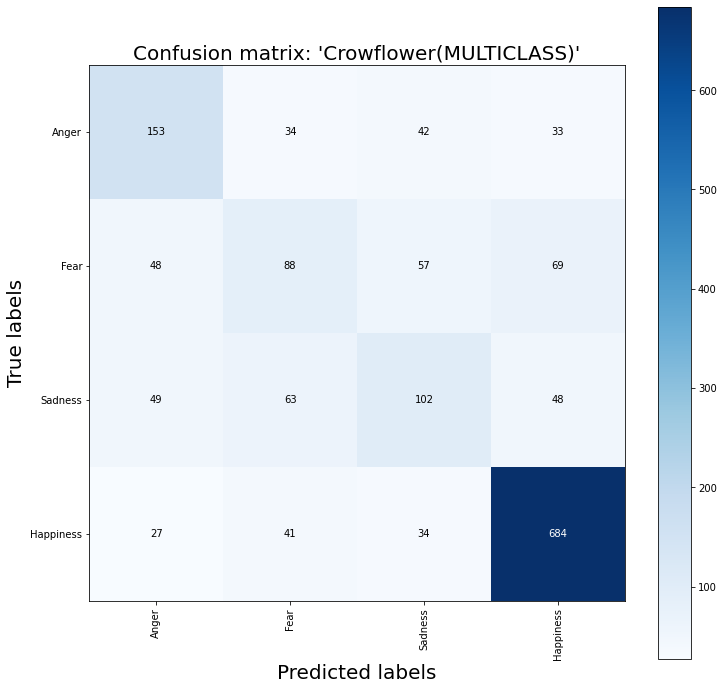

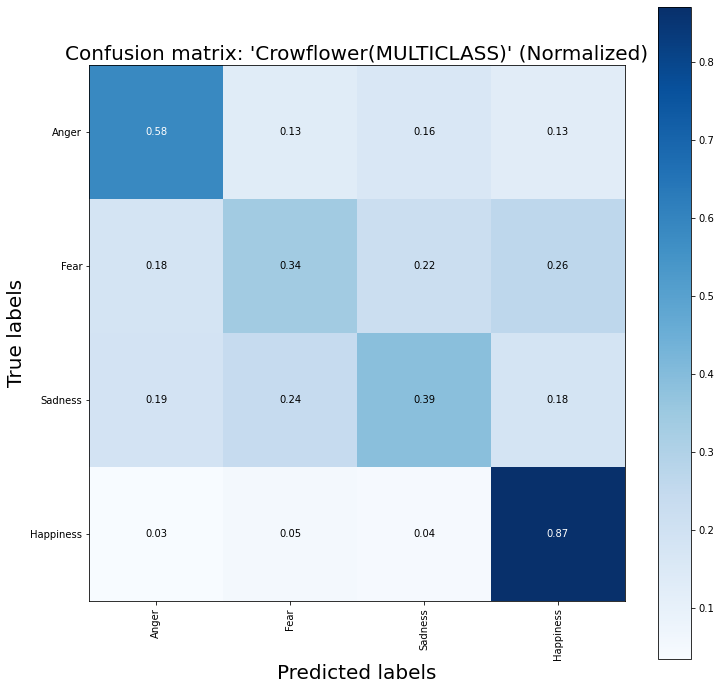

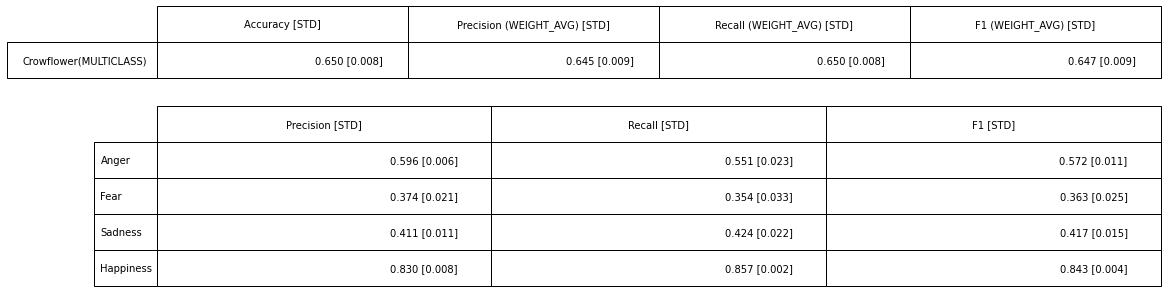

In [ ]:
#Evaluate Crowflower dataset using Bert hierarchical classifier model

train_parameters = {
    "num_epochs": 6,
	  "gradient_clipping": True
}

model_parameters = {
    "batch_size": 64,
    "num_timesteps": 35,
    "num_classes": 4
}

result = run_multiclass_model("Crowflower(MULTICLASS)", model_parameters, train_parameters, load_crowdflower_hierarchical_model)
parameters = ["Crowflower(MULTICLASS)", model_parameters, train_parameters, load_crowdflower_hierarchical_model]
create_report(parameters, run_multiclass_model, parameters[1]["num_classes"], 10)


MODEL: TEC(MULTICLASS)
TRAINING:
Running epoch: 1
Average loss: 1.619
Running epoch: 2
Average loss: 1.276
Running epoch: 3
Average loss: 1.073
Running epoch: 4
Average loss: 0.911
Running epoch: 5
Average loss: 0.836
POST-TRAINING:
Accuracy: 0.687
Accuracy_l1: 0.808
Accuracy_l2: 0.672
EVALUATION REPORT:
Classifier 'TEC(MULTICLASS)':
Accuracy: 0.687
Precision (WEIGHT_AVG): 0.691
Recall (WEIGHT_AVG): 0.687
F1 (WEIGHT_AVG): 0.688
Anger | Precision: 0.526 Recall: 0.619 F1: 0.569 Support: 310
Fear | Precision: 0.707 Recall: 0.623 F1: 0.662 Support: 310
Sadness | Precision: 0.487 Recall: 0.468 F1: 0.477 Support: 310
Happiness | Precision: 0.810 Recall: 0.804 F1: 0.807 Support: 930
CREATING REPORT:
Run: 1
Accuracy: 0.702
Precision (WEIGHT_AVG): 0.707
Recall (WEIGHT_AVG): 0.702
F1 (WEIGHT_AVG): 0.703
Anger | Precision: 0.602 Recall: 0.581 F1: 0.591
Fear | Precision: 0.693 Recall: 0.590 F1: 0.638
Sadness | Precision: 0.485 Recall: 0.574 F1: 0.526
Happiness | Precision: 0.822 Recall: 0.822 F1:

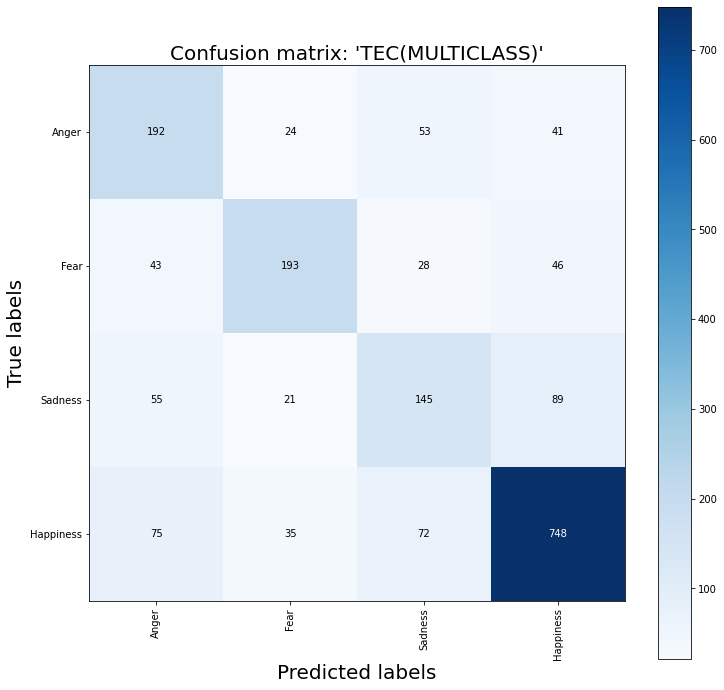

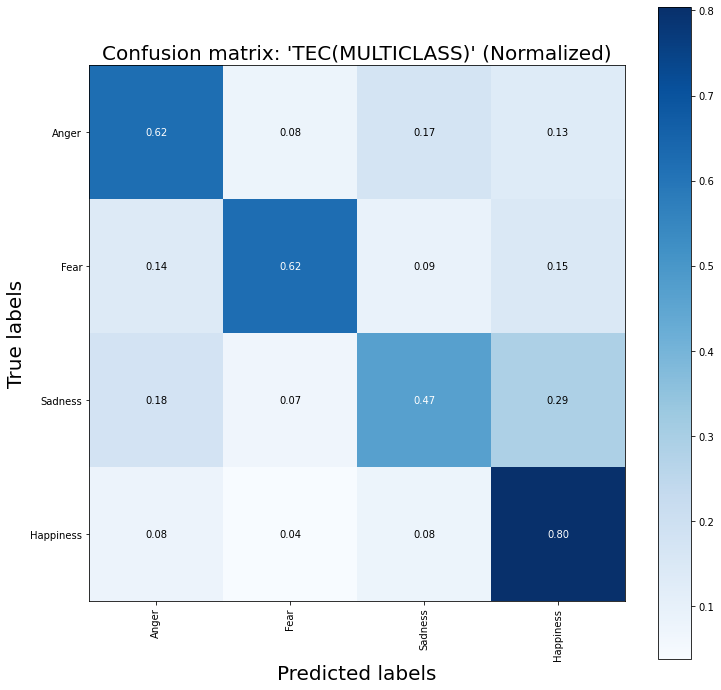

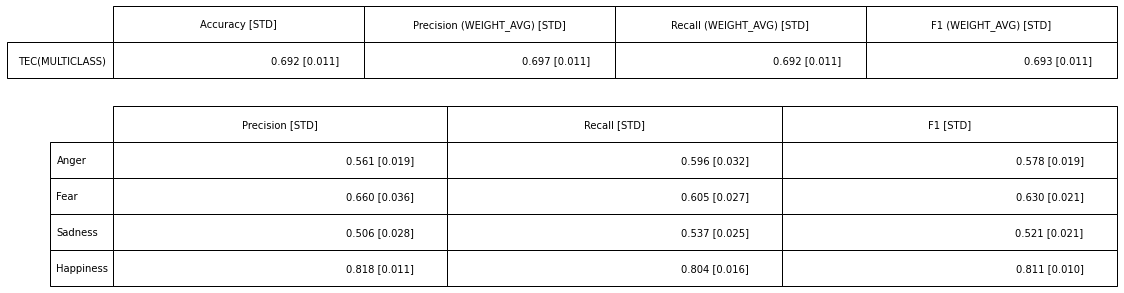

In [ ]:
#Evaluate TEC dataset using Bert hierarchical classifier model
train_parameters = {
    "num_epochs": 5,
	  "gradient_clipping": True
}

model_parameters = {
    "batch_size": 128,
    "num_timesteps": 35,
    "num_classes": 4
}

result = run_multiclass_model("TEC(MULTICLASS)", model_parameters, train_parameters, load_tec_hierarchical_model)
parameters = ["TEC(MULTICLASS)", model_parameters, train_parameters, load_tec_hierarchical_model]
create_report(parameters, run_multiclass_model, parameters[1]["num_classes"], 10)


MODEL: Wang(MULTICLASS)
TRAINING:
Running epoch: 1
Average loss: 1.255
Running epoch: 2
Average loss: 0.969
Running epoch: 3
Average loss: 0.766
Running epoch: 4
Average loss: 0.602
Running epoch: 5
Average loss: 0.497
POST-TRAINING:
Accuracy: 0.719
Accuracy_l1: 0.844
Accuracy_l2: 0.691
EVALUATION REPORT:
Classifier 'Wang(MULTICLASS)':
Accuracy: 0.719
Precision (WEIGHT_AVG): 0.721
Recall (WEIGHT_AVG): 0.719
F1 (WEIGHT_AVG): 0.720
Anger | Precision: 0.666 Recall: 0.654 F1: 0.660 Support: 2000
Fear | Precision: 0.559 Recall: 0.559 F1: 0.559 Support: 2000
Sadness | Precision: 0.559 Recall: 0.583 F1: 0.571 Support: 2000
Happiness | Precision: 0.847 Recall: 0.840 F1: 0.843 Support: 6000
CREATING REPORT:
Run: 1
Accuracy: 0.718
Precision (WEIGHT_AVG): 0.716
Recall (WEIGHT_AVG): 0.718
F1 (WEIGHT_AVG): 0.717
Anger | Precision: 0.653 Recall: 0.634 F1: 0.643
Fear | Precision: 0.574 Recall: 0.547 F1: 0.560
Sadness | Precision: 0.546 Recall: 0.552 F1: 0.549
Happiness | Precision: 0.840 Recall: 0.8

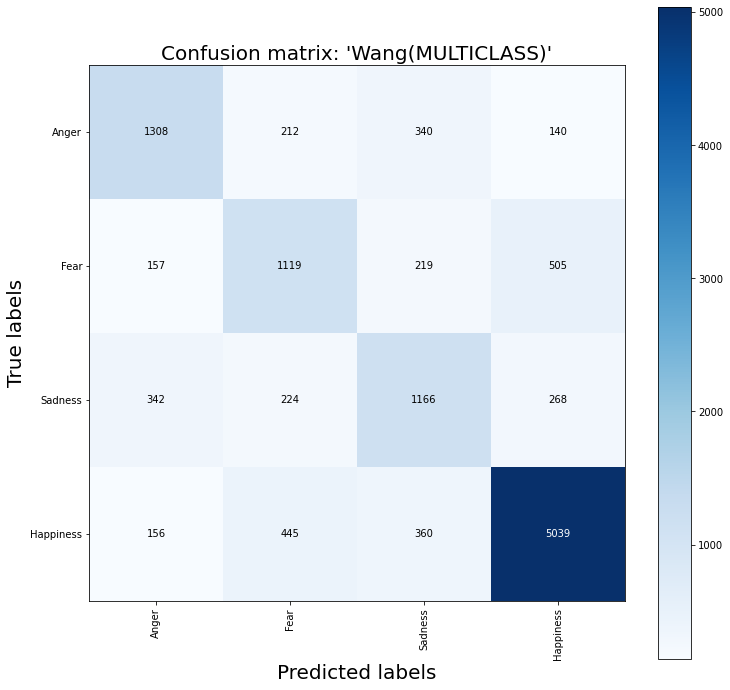

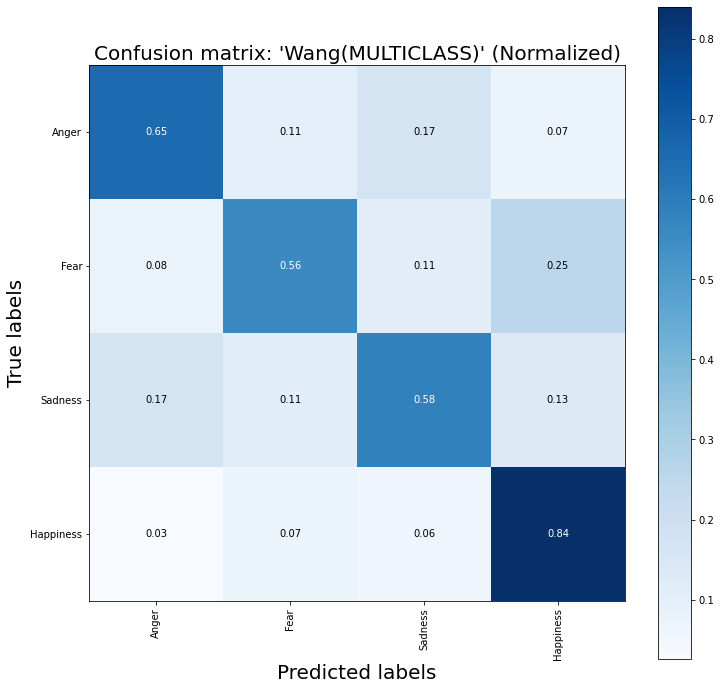

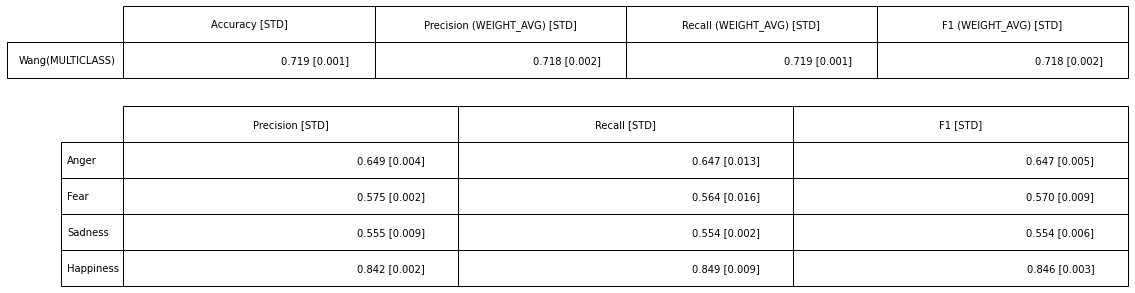

In [ ]:
#Evaluate Wang dataset using Bert hierarchical classifier model

train_parameters = {
    "num_epochs": 5,
	  "gradient_clipping": True
}

model_parameters = {
    "batch_size": 64,
    "num_timesteps": 35,
    "num_classes": 4
}

result = run_multiclass_model("Wang(MULTICLASS)", model_parameters, train_parameters, load_wang_hierarchical_model)
parameters = ["Wang(MULTICLASS)", model_parameters, train_parameters, load_wang_hierarchical_model]
create_report(parameters, run_multiclass_model, parameters[1]["num_classes"], 10)


MODEL: Vent(MULTICLASS)
TRAINING:
Running epoch: 1
Average loss: 1.202
Running epoch: 2
Average loss: 0.953
Running epoch: 3
Average loss: 0.791
Running epoch: 4
Average loss: 0.645
Running epoch: 5
Average loss: 0.545
POST-TRAINING:
Accuracy: 0.725
Accuracy_l1: 0.877
Accuracy_l2: 0.619
EVALUATION REPORT:
Classifier 'Vent(MULTICLASS)':
Accuracy: 0.725
Precision (WEIGHT_AVG): 0.733
Recall (WEIGHT_AVG): 0.725
F1 (WEIGHT_AVG): 0.729
anger | Precision: 0.591 Recall: 0.619 F1: 0.604 Support: 2000
fear | Precision: 0.598 Recall: 0.577 F1: 0.587 Support: 2000
sadness | Precision: 0.529 Recall: 0.590 F1: 0.558 Support: 2000
happiness | Precision: 0.893 Recall: 0.856 F1: 0.874 Support: 6000
CREATING REPORT:
Run: 1
Accuracy: 0.731
Precision (WEIGHT_AVG): 0.738
Recall (WEIGHT_AVG): 0.731
F1 (WEIGHT_AVG): 0.734
anger | Precision: 0.599 Recall: 0.606 F1: 0.602
fear | Precision: 0.616 Recall: 0.601 F1: 0.608
sadness | Precision: 0.548 Recall: 0.616 F1: 0.580
happiness | Precision: 0.888 Recall: 0.8

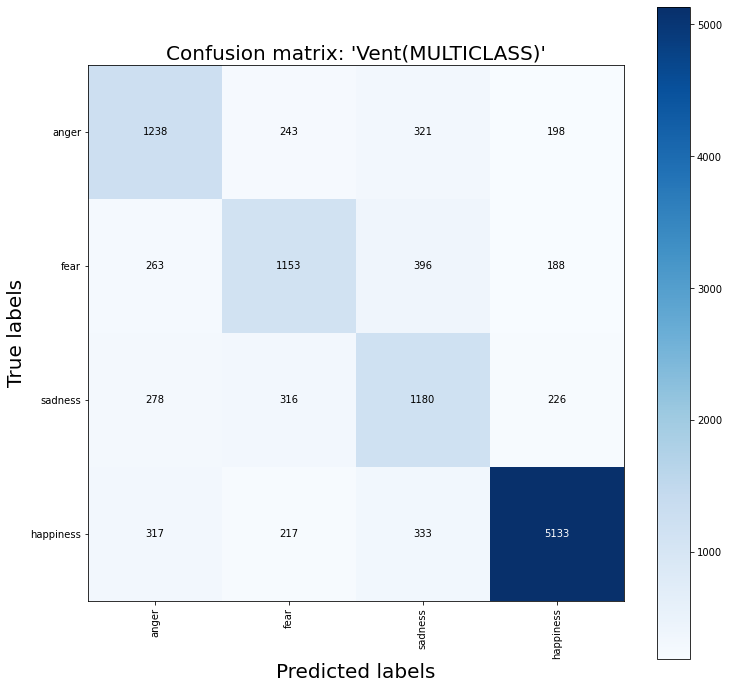

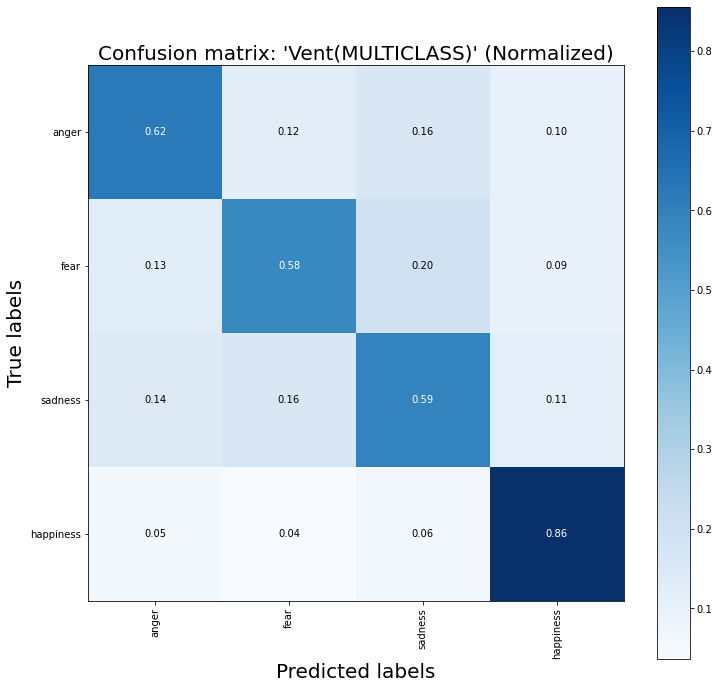

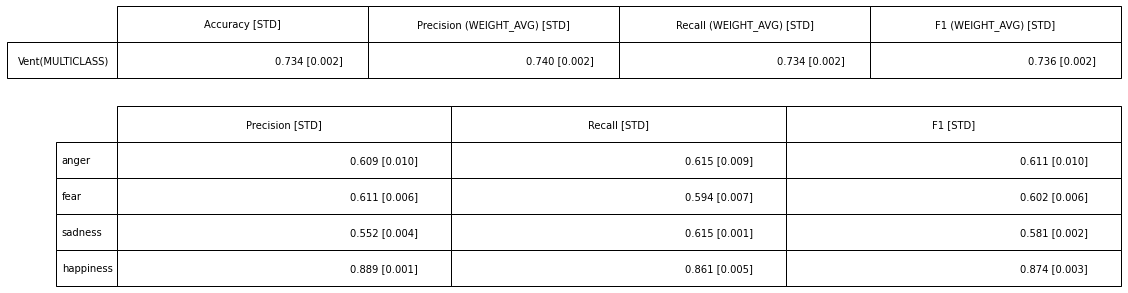

In [ ]:
#Evaluate Vent dataset using Bert hierarchical classifier model

train_parameters = {
    "num_epochs": 5,
	  "gradient_clipping": True
}

model_parameters = {
    "batch_size": 64,
    "num_timesteps": 35,
    "num_classes": 4
}
#The dataset Vent is required to run this cell, which is not provided publicly due to authors restrictions
result = run_multiclass_model("Vent(MULTICLASS)", model_parameters, train_parameters, load_Vent_hierarchical_model)
parameters = ["Vent(MULTICLASS)", model_parameters, train_parameters, load_Vent_hierarchical_model]
create_report(parameters, run_multiclass_model, parameters[1]["num_classes"], 2)